In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import yaml


with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

In [22]:
CPIS2000 = geo_read('Africa_CPIS_2000_shp_path')
CPIS2021 = geo_read('Africa_CPIS_2021_shp_path')
African_countries = read('African_countries_path')

# Reproject onto a common projected CRS (uses meters as units)
CPIS2000 = CPIS2000.to_crs(epsg=3395)
CPIS2021 = CPIS2021.to_crs(epsg=3395)

# Find the area covered by CPIS in each country in meters squared and in hectares
CPIS2000['Area_m2'] = CPIS2000.geometry.area
CPIS2021['Area_m2'] = CPIS2021.geometry.area

CPIS2000['Area_1000ha'] = CPIS2000['Area_m2'] / 10000000
CPIS2021['Area_1000ha'] = CPIS2021['Area_m2'] / 10000000

# Drop the geometry and save the area data as a CSV
cPIS2000 = CPIS2000.drop(columns='geometry')
cPIS2021 = CPIS2021.drop(columns='geometry')

cPIS2000['Year'] = 2000
cPIS2021['Year'] = 2021

output_dir2000 = resolve_path(config['Africa_CPIS_2000_Areas_path'])
output_dir2021 = resolve_path(config['Africa_CPIS_2021_Areas_path'])

cPIS2000.to_csv(output_dir2000, index=False)
cPIS2021.to_csv(output_dir2021, index=False)

CPIS = pd.concat([cPIS2000, cPIS2021])
CPIS.to_csv(resolve_path(config['Africa_CPIS_Areas_path']))

In [23]:
AQUA2000 = read('AQUA_AfricaIrrigation_2000')
AQUA2021 = read('AQUA_AfricaIrrigation_2021')
AQUA = read('AQUA_AfricaIrrigation')

# Compute total area of Irrigation
total_area_2000_AQUA = AQUA2000['Value'].sum()
total_area_2021_AQUA = AQUA2021['Value'].sum()

# Compute the total area of CPIS
total_area_2000_CPIS = CPIS2000['Area_1000ha'].sum()
total_area_2021_CPIS = CPIS2021['Area_1000ha'].sum()

# Compute % of total Irrigation that was CPIS in 2000 and 2020
ratio_2000 = total_area_2000_CPIS/total_area_2000_AQUA
ratio_2021 = total_area_2021_CPIS/total_area_2021_AQUA

print("In 2000, center pivot irrigation systems made up", round(ratio_2000 * 100,2), "% of the total area equipped with irrigation.")
print("In 2021, center pivot irrigation systems made up", round(ratio_2021 * 100,2), "% of the total area equipped with irrigation.")



In 2000, center pivot irrigation systems made up 3.61 % of the total area equipped with irrigation.
In 2021, center pivot irrigation systems made up 5.92 % of the total area equipped with irrigation.


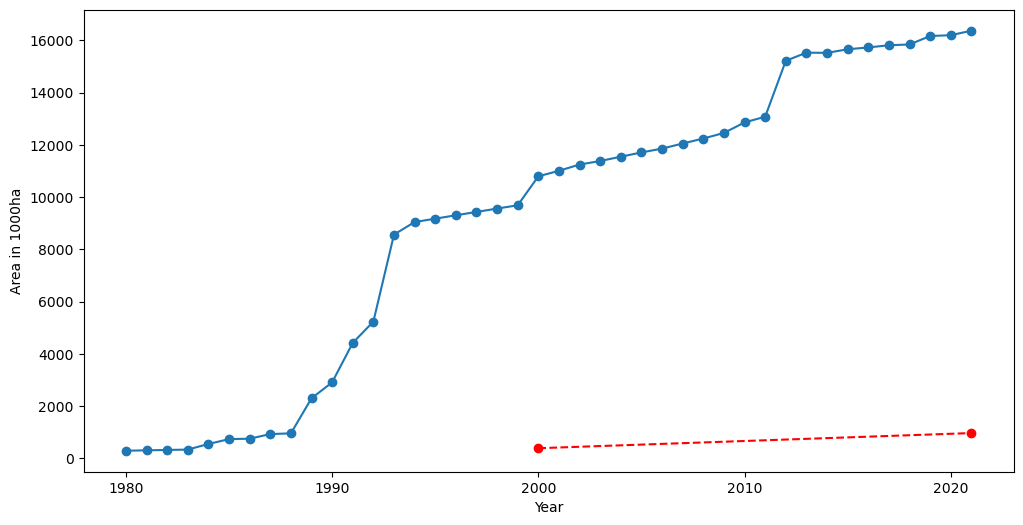

In [24]:
AQUA_yearly = AQUA.groupby('Year')['Value'].sum().reset_index()

CPIS_sum = CPIS.groupby('Year')['Area_1000ha'].sum().reset_index()

plt.figure(figsize = (12,6))
plt.plot(AQUA_yearly['Year'], AQUA_yearly['Value'], label = 'Total Area Equipped for Irrigation', marker = 'o')

plt.scatter(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], color = 'red', label = 'Total Area Covered By Center Pivot Irrigation Systems')

plt.plot(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], 'r--')

plt.xlabel('Year')
plt.ylabel('Area in 1000ha')
plt.show()